In [3]:
# Set up Environment and Requirements Package (In Terminal)
!python3 -m venv ../chmenv
!source ../chmenv/bin/activate
#!pip install jupyter ipykernel nilearn
!python3 -m ipykernel install --user --name=chmenv --display-name "Python (chmenv)"
#remember to switch to notebook/virtual environment kernel

## deactivate

In [2]:
# Install Packages and Maintain Requirements.txt

# pip list # list installed packages
# pip freeze > requirements.txt # create requirements text/override it to update
!pip install -r requirements.txt # install requirements text in new environment
# pip freeze | xargs pip uninstall -y #uninstall all packages

In [3]:
# Import Packages
import pandas as pd
import numpy as np
import os
import matplotlib
import nilearn
from nilearn.image import math_img
from nilearn import plotting, datasets
from pathlib import Path
import glob

In [4]:
# Paths

# Mask (an image of zeros and ones) to mask the brain's data
mask_path = '../ABIDEII/ABIDEII-BNI_1/derivatives/fmriprep/sub-29006/ses-1/anat/sub-29006_ses-1_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

# Structural Image
image_path = '../ABIDEII/ABIDEII-BNI_1/derivatives/fmriprep/sub-29006/ses-1/anat/sub-29006_ses-1_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

In [5]:
# Create a new image that contains only brain data (i.e. an image where the intensity of the voxels outside the brain are set to 0)
# "You could use the function math_img in the image module to multiply the structural image with the mask image. That should yield the image we need to feed our retrieval method."
result_img = math_img("img1 * img2", img1=mask_path, img2=image_path, copy_header_from="img2")

# Save resulting image to new folder for training data
output_dir = Path.cwd() / "data/cleaned_data"
output_dir.mkdir(exist_ok=True, parents=True)
result_img.to_filename(output_dir / "ABIDEII-BNI_1_sub-29006.nii.gz"
)

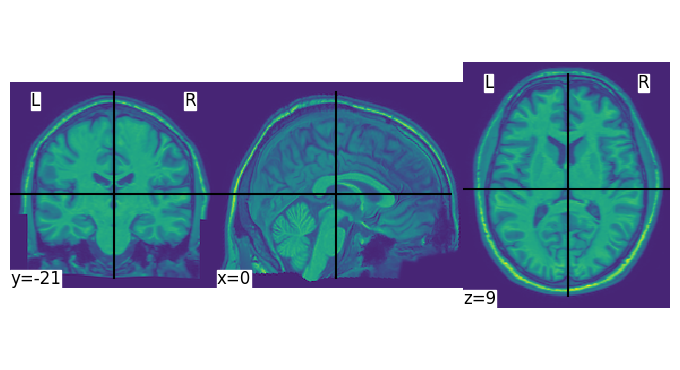

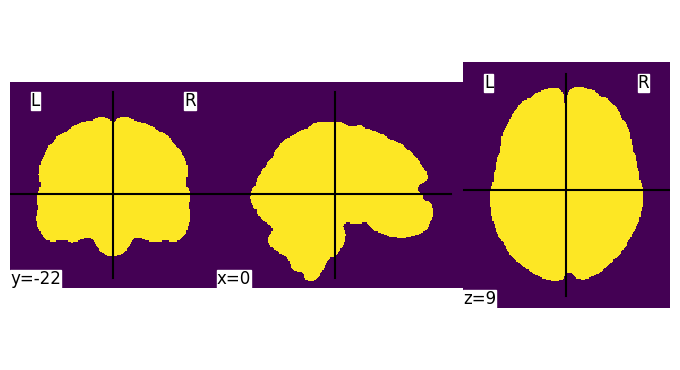

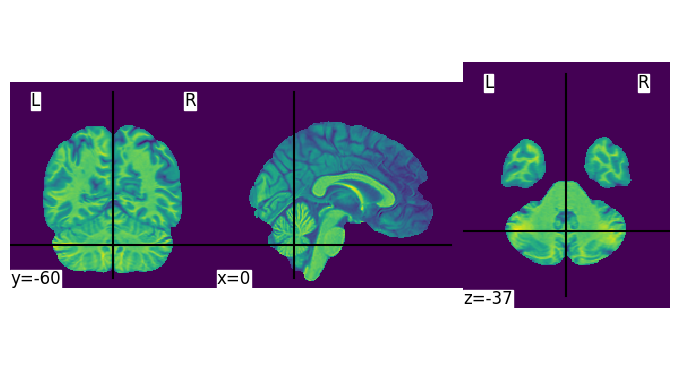

In [6]:
#Plots
plotting.plot_img(image_path)
plotting.plot_img(mask_path)
plotting.plot_img(result_img)

In [8]:
# Import Meta Data / Labels
## Weird thing going on with original data so had to open in excel and re-export as csv to fix
df = pd.read_csv('../ABIDEII/ABIDEII_Composite_Phenotypic.csv')
df.head()

,SITE_ID,SUB_ID,NDAR_GUID,DX_GROUP,PDD_DSM_IV_TR,ASD_DSM_5,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,...,ADI_R_C3_TOTAL,ADI_R_C4_REPETITIVE_USE_OBJECTS,ADI_R_C4_HIGHER,ADI_R_C4_UNUSUAL_SENSORY_INTERESTS,ADI_R_C4_TOTAL,ADI_R_D_AGE_PARENT_NOTICED,ADI_R_D_AGE_FIRST_SINGLE_WORDS,ADI_R_D_AGE_FIRST_PHRASES,ADI_R_D_AGE_WHEN_ABNORMALITY,ADI_R_D_INTERVIEWER_JUDGMENT
0,ABIDEII-BNI_1,29006,NaN,1,NaN,NaN,48.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABIDEII-BNI_1,29007,NaN,1,NaN,NaN,41.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABIDEII-BNI_1,29008,NaN,1,NaN,NaN,59.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABIDEII-BNI_1,29009,NaN,1,NaN,NaN,57.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABIDEII-BNI_1,29010,NaN,1,NaN,NaN,45.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_long = pd.read_csv('../ABIDEII/ABIDEII_Long_Composite_Phenotypic.csv')
df_long.head()

,SITE_ID,SUB_ID,SESSION,NDAR_GUID,DX_GROUP,PDD_DSM_IV_TR,ASD_DSM_5,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,ADI_R_C3_TOTAL,ADI_R_C4_REPETITIVE_USE_OBJECTS,ADI_R_C4_HIGHER,ADI_R_C4_UNUSUAL_SENSORY_INTERESTS,ADI_R_C4_TOTAL,ADI_R_D_AGE_PARENT_NOTICED,ADI_R_D_AGE_FIRST_SINGLE_WORDS,ADI_R_D_AGE_FIRST_PHRASES,ADI_R_D_AGE_WHEN_ABNORMALITY,ADI_R_D_INTERVIEWER_JUDGMENT
0,ABIDEI-PITT,50002,Baseline,NaN,1,1,NaN,16.77,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABIDEII-UPSM_Long,50002,Followup_1,NaN,1,1,NaN,18.49,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABIDEI-PITT,50005,Baseline,NaN,1,1,NaN,13.73,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABIDEII-UPSM_Long,50005,Followup_1,NaN,1,1,NaN,15.55,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABIDEI-PITT,50006,Baseline,NaN,1,1,NaN,13.37,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Training Image Directory
output_dir = Path.cwd() / "data/cleaned_data"
output_dir.mkdir(exist_ok=True, parents=True)

# Load the CSV file
csv_file = "../ABIDEII/ABIDEII_Composite_Phenotypic.csv"  # Annotations File
data = pd.read_csv(csv_file)

# Base folder path
base_path = "../ABIDEII"

# Iterate through each row in the CSV
for index, row in data.iterrows():
    site_id = row['SITE_ID']
    sub_id = row['SUB_ID']
    
    # Construct the anat folder path
    anat_folder = os.path.join(base_path, f"{site_id}/derivatives/fmriprep/sub-{sub_id}/ses-1/anat")

    if os.path.exists(anat_folder):
        # Mask (an image of zeros and ones) to mask the brain's data
        mask_path = glob.glob(os.path.join(anat_folder, "*brain_mask.nii.gz"))

        # Structural Image
        image_path = glob.glob(os.path.join(anat_folder, "*T1w.nii.gz"))
        
        if (mask_path != []) | (image_path != []):
            # Result Image that contains only brain data
            result_img = math_img("img1 * img2", img1=mask_path, img2=image_path, copy_header_from="img2")

            # Save resulting image to new folder for training data
            output_dir = Path.cwd() / "data/cleaned_data"
            output_dir.mkdir(exist_ok=True, parents=True)
            result_img.to_filename(output_dir / f"{site_id}_sub-{sub_id}.nii.gz")
        else:
            # Skip file
            print(f"Site ID: {site_id} and Subject ID : {sub_id} exist but the mask or image file(s) do not, skipping...")
            
    else:
        # Skip file
        print(f"Site ID: {site_id} and Subject ID : {sub_id} do not exist, skipping...")


Site ID: ABIDEII-BNI_1 and Subject ID : 29031 do not exist, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29866 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29872 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29873 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29875 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29880 do not exist, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29890 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29891 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29893 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 29894 exist but the mask or image file(s) do not, skipping...
Site ID: ABIDEII-EMC_1 and Subject ID : 

In [17]:
path = './data/cleaned_data'
len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

870